In [2]:
import tensorflow as tf

try: 
 tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError: 
 raise BaseException("CAN'T CONNECT TO A TPU")

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

BaseException: CAN'T CONNECT TO A TPU

In [11]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import math
import logging

from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

logger = logging.getLogger(__name__)

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info("saving %s", self.config.ckpt_path)
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=config.batch_size,
                                num_workers=config.num_workers)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")

            if not is_train:
                test_loss = float(np.mean(losses))
                logger.info("test loss: %f", test_loss)
                return test_loss

        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()


In [13]:
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 48
    n_head = 25
    n_embd = 1600

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [14]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    return x


In [15]:
# !git clone https://github.com/karpathy/minGPT.git
# %cd minGPT/

In [16]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [17]:
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [18]:
#from mingpt.utils import set_seed
set_seed(42)

In [19]:
from torch.utils.data import DataLoader, Subset

In [20]:
#root = '/kaggle/input/mnist-dataset/'

#train_data = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
#test_data  = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=False)
#print(len(train_data), len(test_data))

In [21]:
#from tensorflow.keras.datasets import mnist
#(train_images, _), (test_images, _) = mnist.load_data()

In [28]:
import struct
import numpy as np

train_image_path = '/kaggle/input/mnist-dataset/train-images.idx3-ubyte'
train_labels_path = '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
test_image_path = '/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_path = '/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'

def read_idx_images(filename):
    """Read images in IDX format."""
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def read_idx_labels(filename):
    """Read labels in IDX format."""
    with open(filename, 'rb') as f:
        magic_number, num_labels = struct.unpack('>II', f.read(8))  # Odczytaj magiczną liczbę i liczbę etykiet
        return np.frombuffer(f.read(), dtype=np.uint8)

train_images = read_idx_images(train_image_path)
train_labels = read_idx_labels(train_labels_path)
test_images = read_idx_images(test_image_path)
test_labels = read_idx_labels(test_labels_path)

train_data = list(zip(train_images, train_labels))
test_data = list(zip(test_images, test_labels))

print(len(train_data), len(test_data))

60000 10000


In [29]:
indices = [i for i, (img, label) in enumerate(train_data) if label == 5]
train_dataset = Subset(train_data, indices)

test_dataset = Subset(test_data, [i for i, (img, label) in enumerate(test_data) if label == 5])

In [30]:
# Utwórz Subset dla danych testowych zawierający tylko obrazy z etykietą 5
#test_indices = [i for i, (img, label) in enumerate(test_data) if label == 5]
#test_subset = Subset(range(len(test_data)), test_indices)

# Utwórz DataLoader dla Subset
#train_loader = DataLoader(train_data, batch_size=64, sampler=train_subset)
#test_loader = DataLoader(test_data, batch_size=64, sampler=test_subset)

In [31]:
train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x7c2cfc8c5ab0>,
 <torch.utils.data.dataset.Subset at 0x7c2cfc8c77c0>)

In [32]:
#train_data

5
0
4
1
9
2
1
3
1
4
3
5
3
6
1
7


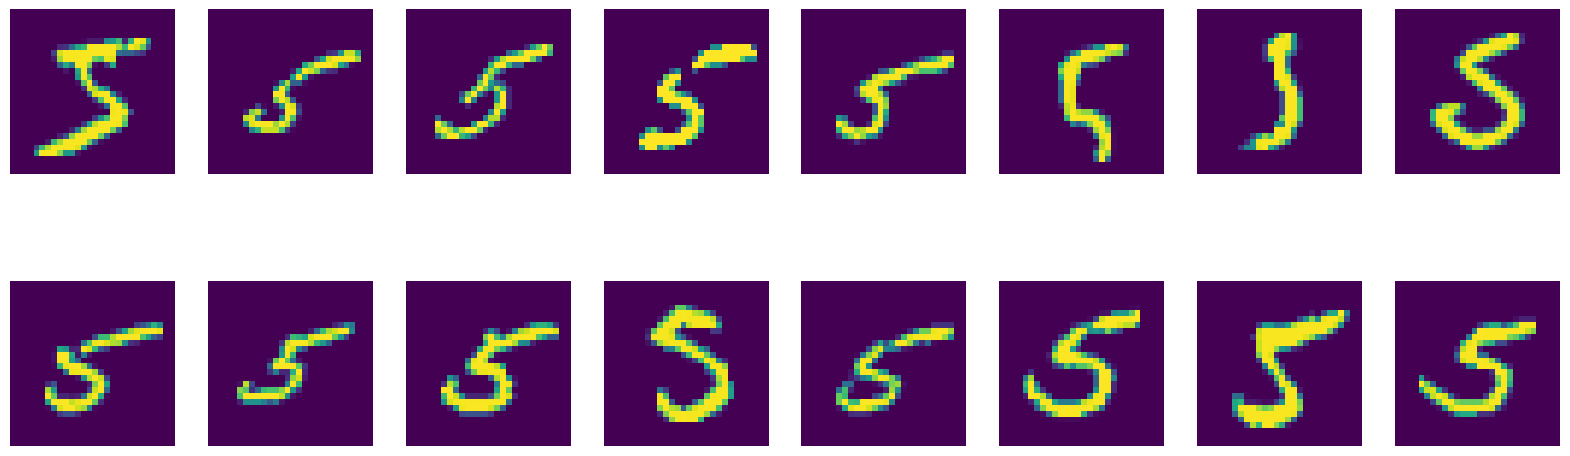

In [34]:
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    
    # encode and decode random data
    x, y = train_dataset.__getitem__(i)
    xpt = torch.from_numpy(np.array(x)).float().view(28*28)
  
    
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(xpt.view(28,28).numpy().astype(np.uint8))
    #plt.imshow(train_images[i].astype(np.uint8))
    plt.axis('off')
    print(train_labels[i])
    

In [35]:
from torch.utils.data import Dataset
class ImageDataset(Dataset):
    """
    wrap up the pytorch CIFAR-10 dataset into our own, which will convert images into sequences of integers
    """
    
    def __init__(self, pt_dataset):
        self.pt_dataset = pt_dataset
        
        
        self.vocab_size = 256
        self.block_size = 28*28 - 1
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1) # flatten out all pixels
        x = x.long() # reshuffle pixels with any fixed permutation and -> float
        
        return x[:-1],x[1:] # always just predict the next one in the sequence

train_dataset = ImageDataset(train_dataset)
test_dataset = ImageDataset(test_dataset)
train_dataset[10][0].size() # one example image flattened out into integers

torch.Size([783])

In [36]:
!pwd

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/kaggle/working


In [37]:
#from mingpt.model import GPT, GPTConfig, GPT1Config

# we'll do something a bit smaller
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=6, n_head=8, n_embd=256)
model = GPT(mconf)

In [70]:
#from mingpt.trainer import Trainer, TrainerConfig

tokens_per_epoch = len(train_data) * train_dataset.block_size
train_epochs = 4 # todo run a bigger model and longer, this is tiny

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=8, learning_rate=3e-3,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='mnist.pt',
                      num_workers=8)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()

epoch 1 iter 677: train loss 0.95810. lr 2.710000e-04: 100%|██████████| 678/678 [01:18<00:00,  8.65it/s]
epoch 2 iter 677: train loss 0.70976. lr 5.420000e-04: 100%|██████████| 678/678 [01:18<00:00,  8.64it/s]
epoch 3 iter 677: train loss 0.47135. lr 8.130000e-04: 100%|██████████| 678/678 [01:18<00:00,  8.68it/s]
epoch 4 iter 677: train loss 0.80395. lr 1.084000e-03: 100%|██████████| 678/678 [01:18<00:00,  8.67it/s]


In [71]:
checkpoint = torch.load('mnist.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [72]:
counts = torch.ones(256) # start counts as 1 not zero, this is called "smoothing"

nest = 5000 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset[i]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()

In [73]:
#from mingpt.utils import sample

n_samples = 32
start_pixel = np.random.choice(np.arange(256), size=(n_samples, 1), replace=True, p=prob)
start_pixel = torch.from_numpy(start_pixel).to(trainer.device)
pixels = sample(model, start_pixel, 28*28-1, temperature=1.0, sample=True, top_k=100)

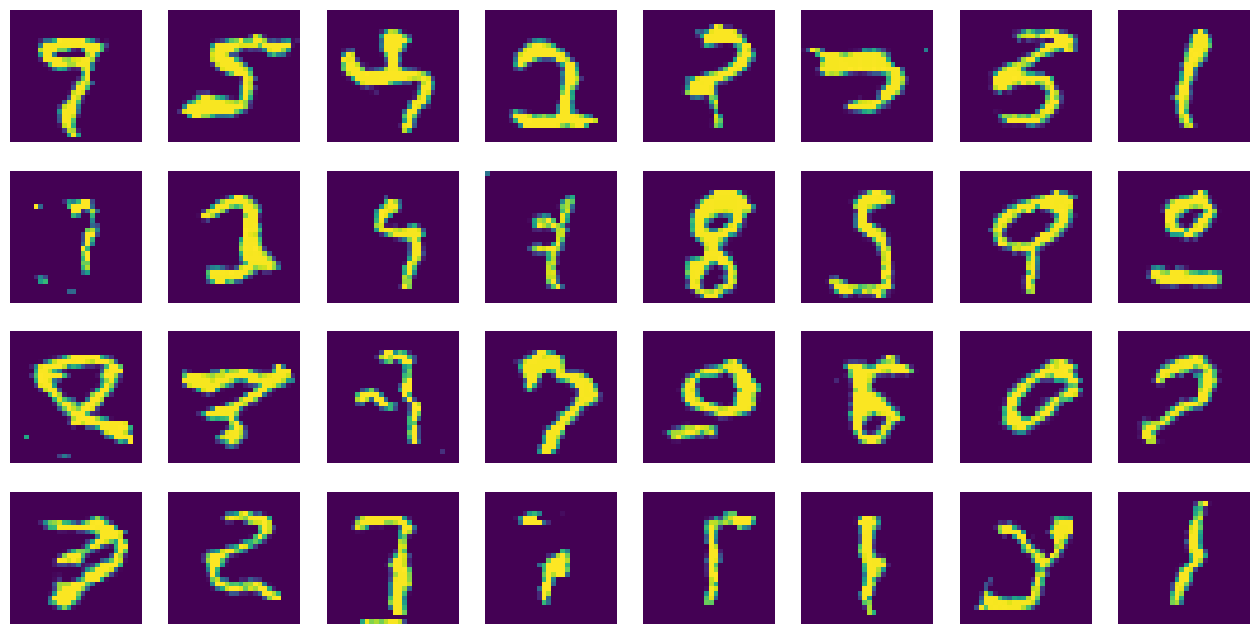

In [74]:
ncol = 8
nrow = n_samples // ncol
plt.figure(figsize=(16, 8))
for i in range(n_samples):
    pxi = pixels[i] # note: undo the encoding permutation
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(pxi.view(28,28).cpu().numpy().astype(np.uint8))
    plt.axis('off')